Test and demonstrate functionality from `spiral.py`

In [3]:
import sys,os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import importlib

In [2]:
# import lmod
# await lmod.purge(force=True)
# await lmod.load('ncarenv/23.10', 'texlive/20220321', 'gcc/12.2.0', 'ncarcompilers/1.0.0', 'ucx/1.14.1', 'openmpi/4.1.6', 'hdf5/1.12.2', 'netcdf/4.9.2', 'cuda/11.8.0')

In [3]:
!echo $CXX

icpx


In [4]:
# !module load cuda/11.8 ncarenv

In [5]:
# !module unload intel

In [6]:
# !module load gcc

In [7]:
# module unload intel

In [8]:
# !echo $CXX

In [9]:
# os.system('module load cuda/11.8 ncarenv')

In [10]:
# os.system('module swap intel gcc')

In [11]:
os.environ['CXX']

'icpx'

In [12]:
!echo $CXX

icpx


In [17]:
# load file path information from the home directory
file_path_yml = os.path.join(os.environ["HOME"], ".ncar_config_derecho.yaml")
path_data = {}
with open(file_path_yml, "r") as r:
    path_data = yaml.safe_load(r)

In [18]:
dirP_str = os.path.join(
    path_data["ptv_collection_path"], "SpiralTorch", "python"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [19]:
from SpiralTorch import spiral
from SpiralTorch import loss
from SpiralTorch import fista

In [20]:
os.environ['PYTHONPATH']

'/glade/u/home/mhayman/Projects/GitHub/ptv-mpd/python:/glade/u/home/mhayman/Projects/GitHub/gcloptimus/python:/glade/u/home/mhayman/Python/miles-holodec'

Some notes on getting fista_cuf to compile:
There were initially some `UnicodeDecodeError` which were elimited by deleting the `__pycache__` folder in the `cuda` subfolder

There is now an error being thrown during load/compile
```
CalledProcessError: Command '['ninja', '-v']' returned non-zero exit status 1.
```
This is almost definitely caused by PyTorch using the `-v` argument instead of `--version`

In [17]:
import SpiralTorch.cuda.st_fista_cuf

fista_cuf directory
/glade/u/home/mhayman/Python/ptv_collection/SpiralTorch/python/SpiralTorch/cuda


Using /glade/u/home/mhayman/.cache/torch_extensions/py312_cu118 as PyTorch extensions root...
/glade/work/mhayman/conda-envs/ptv-casper-cuda/lib/python3.12/site-packages/torch/utils/cpp_extension.py:363: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (icpx) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using icpx, and then you can also use
icpx to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(
Detected CUDA files, patching ldflags
Emitting ninja build file /glade/u/home/mha

1.12.0


ImportError: /glade/u/home/mhayman/.cache/torch_extensions/py312_cu118/st_fista_subproblem/st_fista_subproblem.so: cannot open shared object file: No such file or directory

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
# device = torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

dtype = torch.float64

Preparing to use device cuda:0


In [5]:
torch.__version__

'2.3.0'

# Single variable Spiral Poisson Noise
Create and process Poisson noisy images

### Generate some data to denoise

In [13]:
x_axis = np.linspace(-10,10,64)
y_axis = np.linspace(-10,10,128)
x_ax_mesh,y_ax_mesh = np.meshgrid(x_axis,y_axis)

rec_count = 80

# uniform distribution
# rec_x_position_arr = 20*(np.random.rand(rec_count)-0.5)
# rec_y_position_arr = 20*(np.random.rand(rec_count)-0.5)
# normal distribution
rec_x_position_arr = 5*(np.random.randn(rec_count))
rec_y_position_arr = 5*(np.random.randn(rec_count))
rec_x_arr = np.random.randn(rec_count)*5
rec_y_arr = np.random.randn(rec_count)*5
alpha_rec_arr = 20*np.random.rand(rec_count)

alpha_arr = np.zeros((y_axis.size,x_axis.size))

for idx in range(rec_count):
    rec_idx = np.where((y_ax_mesh >= rec_y_position_arr[idx]-rec_y_arr[idx]/2) & (y_ax_mesh <= rec_y_position_arr[idx]+rec_y_arr[idx]/2) & \
             (x_ax_mesh >= rec_x_position_arr[idx]-rec_x_arr[idx]/2) & (x_ax_mesh <= rec_x_position_arr[idx]+rec_x_arr[idx]/2))
    alpha_arr[rec_idx]+=alpha_rec_arr[idx]

alpha_arr+= 4

In [14]:
# create fit and validation data for the scene
y_obs_fit = np.random.poisson(alpha_arr)
y_obs_val = np.random.poisson(alpha_arr)

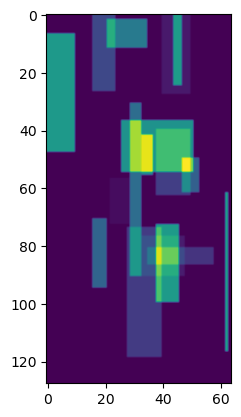

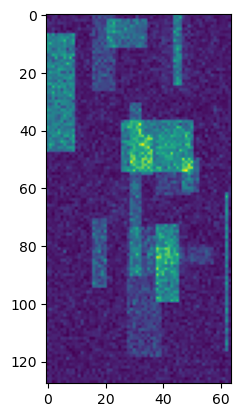

In [15]:
plt.figure()
plt.imshow(alpha_arr)

plt.figure()
plt.imshow(y_obs_fit)

### Example of single Sparsa subproblem
Basic one-off setup for single sparse instance

In [16]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'
max_iter = 2000
loss_fnc = loss.pois_loss_fn

The forward model function accepts the estimated state variable `x` (dict) and outputs a dictionary `y` of the observation noise models.  In the simplest form, this is just the mean of the PDF (such as with Poisson noise).  However this can be applied to any PDF which may have multiple parameters.

The noise model output dict needs to match with the expected forward model kwargs in the loss function.

In [17]:
def fwd_model_photons(**x):
    # really simple direct forward model
    return {'y_mean_est':torch.exp(x['backscatter'])+1e-20}

Similar to the forward mode, the observations for each channel need to align with the expected observation kwargs in the loss function definition.  In the case of the Poisson noise model, it expects `counts` (for photon counts in a bin) and `shot_count` for the number of laser shots in a bin.

In [18]:
y_obs_dct_lst = [
    {'counts':torch.tensor(y_obs_fit,dtype=dtype,device=device),
    'shot_count':torch.ones((y_obs_fit.shape[0],1),dtype=dtype,device=device)},
]
fwd_model_lst = [fwd_model_photons]

The estimated state variable `x` can consist of multiple terms which have various relationships to each observed channel.  The entries for the state variable need to align with the expected kwargs in the forward model functions or methods.

In [19]:
x0 = {'backscatter':torch.zeros(y_obs_fit.shape,dtype=dtype,device=device)}

In [20]:
subprob = sparsa.sparsa_torch_autograd(device,dtype)
subprob.load_fit_parameters(x0,
                            y_obs_dct_lst,
                            fwd_model_lst,
                            'backscatter')
subprob.set_loss_fn(loss_fnc)
subprob.set_fista(fista_ver_str) # use jit-fista
subprob.set_penalty_weight(1.0e0)
subprob.set_max_iter(max_iter)
subprob.set_alpha_min(1e3)  # this is pretty key to establishing stability in the processing.  1 is too small.
subprob.alpha
# subprob.set_alpha(1e8)

tensor(1., device='cuda:0', dtype=torch.float64)

In [21]:
subprob.solve_sparsa_subprob()

'Found Minimum for eps 1e-05'

In [22]:
subprob.alpha

tensor(1000., device='cuda:0', dtype=torch.float64)

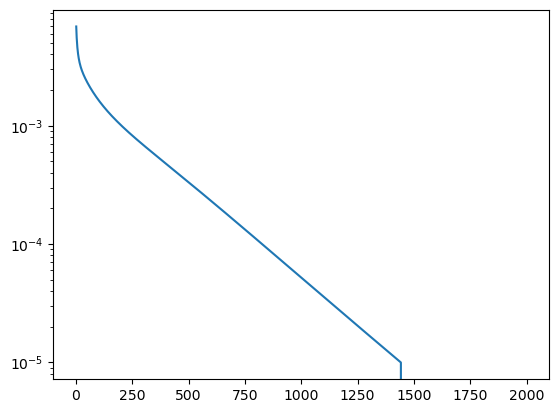

In [23]:
plt.figure()
plt.plot(subprob.rel_step_tnsr.detach().cpu().numpy())
plt.yscale('log')

In [24]:
x_est_arr = torch.exp(subprob.x).cpu().detach().numpy()

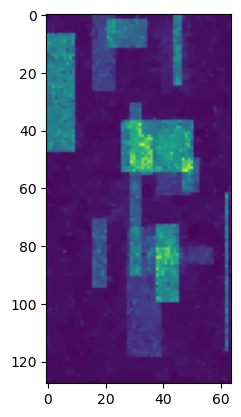

In [25]:
plt.figure()
plt.imshow(x_est_arr)

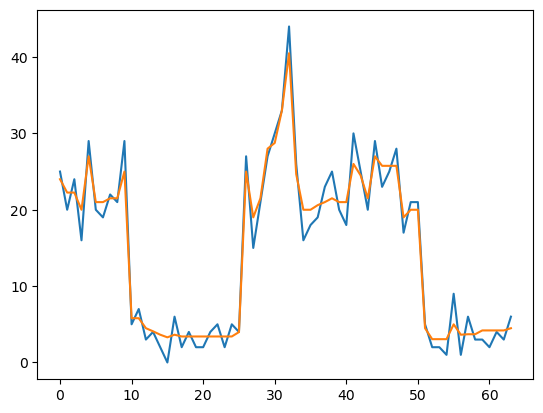

In [26]:
plt.figure()
plt.plot(y_obs_dct_lst[0]['counts'].cpu().detach().numpy()[40,:])
plt.plot(x_est_arr[40,:])

### run and optimize regularizer

In [27]:
max_iter = 2000
reg_arr = np.logspace(0,1,10)
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'

In [28]:
# setup validation data for cross validation
y_val_dct_lst = [
    {'counts':torch.tensor(y_obs_val,dtype=dtype,device=device),
    'shot_count':torch.ones((y_obs_val.shape[0],1),dtype=dtype,device=device)},
]

In [29]:
# setup the sparsa subproblem
subprob = sparsa.sparsa_torch_autograd(device,dtype)
subprob.load_fit_parameters(x0,
                            y_obs_dct_lst,
                            fwd_model_lst,
                            'backscatter')
subprob.set_loss_fn(loss_fnc)
subprob.set_fista(fista_ver_str)
subprob.set_max_iter(max_iter)
subprob.set_alpha_min(1e3)  # this is pretty key to creating stability in the processing.  1 is too small.

In [30]:
x_sol_lst = []
vld_sol_lst = []
step_size_lst = []
iter_lst = []
for red_idx,reg in enumerate(reg_arr):
    # initialize to run the subproblem for this regularizer
    subprob.set_fit_param(x0)
    subprob.reset_iterations()
    subprob.set_penalty_weight(reg)
    subprob.set_alpha(1.0)  # strangely this performs better when initialized to 1.0 which is out of the min/max limits

    sol_str = subprob.solve_sparsa_subprob()

    x_sol_dct = {'backscatter':subprob.x}
    x_sol_lst.append(x_sol_dct)
    
    vld_loss = 0
    for ch_idx,ch_fnc in enumerate(fwd_model_lst):
        mod_dct = ch_fnc(**x_sol_dct)
        vld_loss+=loss_fnc(**mod_dct,**y_val_dct_lst[ch_idx]).item()
    print(f"{reg:e}: {vld_loss:e}: "+sol_str)

    vld_sol_lst.append(vld_loss)
    step_size_lst.append(subprob.rel_step_tnsr.detach().cpu().numpy())
    iter_lst.append(subprob.loop_iter)
    
# self.x[var].data = self.subprob_dct[var].x.data

1.000000e+00: -1.008448e+05: Found Minimum for eps 1e-05
1.291550e+00: -1.010453e+05: Found Minimum for eps 1e-05
1.668101e+00: -1.011565e+05: Found Minimum for eps 1e-05
2.154435e+00: -1.012024e+05: Found Minimum for eps 1e-05
2.782559e+00: -1.011806e+05: Found Minimum for eps 1e-05
3.593814e+00: -1.010685e+05: Found Minimum for eps 1e-05
4.641589e+00: -1.008316e+05: Found Minimum for eps 1e-05
5.994843e+00: -1.004649e+05: Found Minimum for eps 1e-05
7.742637e+00: -1.000382e+05: Found Minimum for eps 1e-05
1.000000e+01: -9.938015e+04: Found Minimum for eps 1e-05


In [31]:
subprob.alpha

tensor(1000., device='cuda:0', dtype=torch.float64)

In [32]:
vld_idx = np.argsort(vld_sol_lst)

In [33]:
sol_idx = np.argmin(vld_sol_lst)

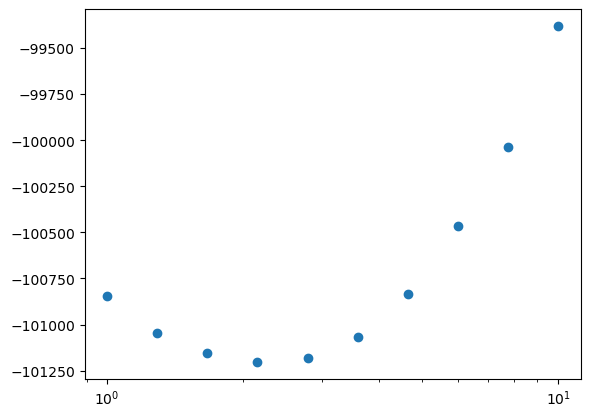

In [34]:
plt.figure()
plt.scatter(reg_arr,np.array(vld_sol_lst))
plt.xscale('log')

In [35]:
fwd_mod_sol = fwd_model_lst[0](**x_sol_lst[sol_idx])
fwd_mod_arr = fwd_mod_sol['y_mean_est'].detach().cpu().numpy()

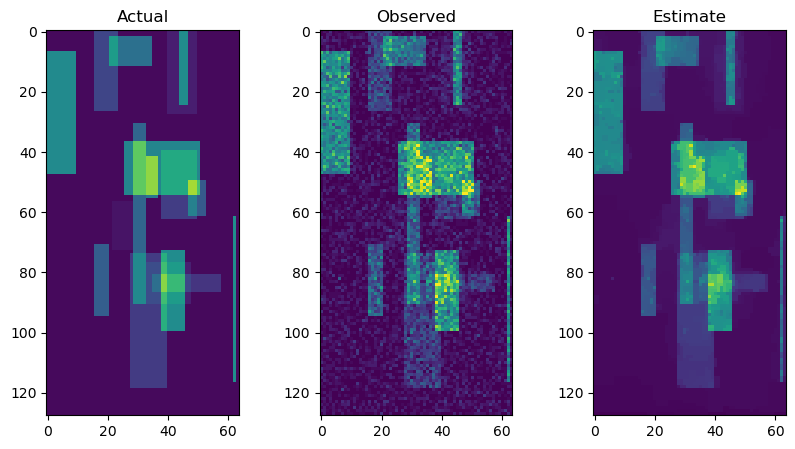

In [46]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
im = ax[2].imshow(fwd_mod_arr)
ax[2].set_title("Estimate")
clim = im.get_clim()

im = ax[0].imshow(alpha_arr)
ax[0].set_title("Actual")
im.set_clim(clim)

im = ax[1].imshow(y_obs_fit)
ax[1].set_title("Observed")
im.set_clim(clim)

Text(0, 0.5, 'counts')

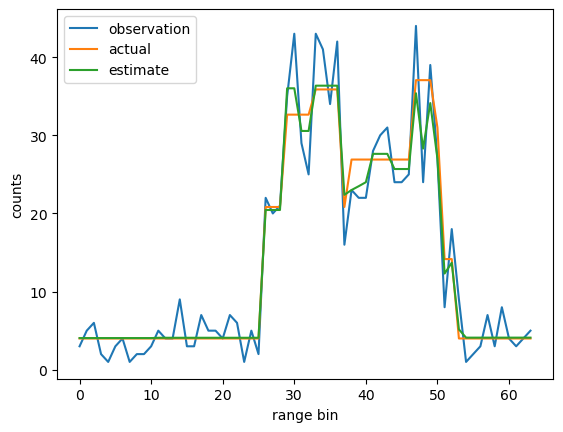

In [37]:
cross_idx = 50
plt.figure()
plt.plot(y_obs_dct_lst[0]['counts'].cpu().detach().numpy()[cross_idx,:],label='observation')
plt.plot(alpha_arr[cross_idx,:],label='actual')
plt.plot(fwd_mod_arr[cross_idx,:],label='estimate')
plt.legend()
plt.xlabel('range bin')
plt.ylabel('counts')

In [73]:
vld_loss

tensor(8192., device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [22]:
import pathlib

In [23]:
str(pathlib.Path(__file__).parent.resolve())

NameError: name '__file__' is not defined

### A little aside to test FISTA instances

In [119]:
alpha = 1e10
x_lb = torch.zeros_like(y_obs_dct_lst[0]['counts'])-10
x_ub = torch.zeros_like(y_obs_dct_lst[0]['counts'])+10
cu_fista = SpiralTorch.cuda.fista_cuf.solve_FISTA_subproblem_kernel
jit_fista = torch.jit.trace(fista.solve_FISTA_subproblem_jit,(x0['backscatter'],torch.tensor(1e-1/alpha,device=device,dtype=dtype),
                                                    x_lb,x_ub))

NameError: name 'SpiralTorch' is not defined

In [120]:
res_cu = cu_fista(x0['backscatter'],torch.tensor(1e-1/alpha,device=device,dtype=dtype),x_lb,x_ub)
res_jit = jit_fista(x0['backscatter'],torch.tensor(1e-1/alpha,device=device,dtype=dtype),x_lb,x_ub)

NameError: name 'cu_fista' is not defined

In [18]:
torch.sum(res_cu)

tensor(0., device='cuda:0', dtype=torch.float64)

In [19]:
torch.sum(res_jit)

tensor(32768.0000, device='cuda:0', dtype=torch.float64)

# Multi-variable Spiral

### Create data to denoise
Generate a scene of data similar to depolarization where one channel observes a parallel and perpendicular polarization term such that the mean photon flux in each channel is

$\alpha_1 = \beta(1-d/2)$

$\alpha_2 = \frac{1}{2}\beta d$

and the observations are 

$y_1 \sim Poisson(\alpha_1)$

$y_2 \sim Poisson(\alpha_2)$

In [21]:
x_axis = np.linspace(-10,10,64)
y_axis = np.linspace(-10,10,128)
x_ax_mesh,y_ax_mesh = np.meshgrid(x_axis,y_axis)

rec_count = 80
ch_count = 2

# uniform distribution
# rec_x_position_arr = 20*(np.random.rand(rec_count)-0.5)
# rec_y_position_arr = 20*(np.random.rand(rec_count)-0.5)
# normal distribution
rec_x_position_arr = 5*(np.random.randn(rec_count))
rec_y_position_arr = 5*(np.random.randn(rec_count))
rec_x_arr = np.random.randn(rec_count)*5
rec_y_arr = np.random.randn(rec_count)*5
beta_rec_arr = 20*np.random.rand(rec_count)
d_rec_arr = np.random.rand(rec_count)

beta_bg = 4
d_bg = 0.1

alpha_arr_lst = []
for idx in range(ch_count):
    if idx == 0:
        alpha_arr_lst.append(np.zeros((y_axis.size,x_axis.size))+0.5*beta_bg*(1-d_bg))
    elif idx == 1:
        alpha_arr_lst.append(np.zeros((y_axis.size,x_axis.size))+0.5*beta_bg*d_bg)

for idx in range(rec_count):
    rec_idx = np.where((y_ax_mesh >= rec_y_position_arr[idx]-rec_y_arr[idx]/2) & (y_ax_mesh <= rec_y_position_arr[idx]+rec_y_arr[idx]/2) & \
             (x_ax_mesh >= rec_x_position_arr[idx]-rec_x_arr[idx]/2) & (x_ax_mesh <= rec_x_position_arr[idx]+rec_x_arr[idx]/2))
    
    alpha_arr_lst[0][rec_idx]+=beta_rec_arr[idx]*(1-0.5*d_rec_arr[idx])
    alpha_arr_lst[1][rec_idx]+=0.5*beta_rec_arr[idx]*d_rec_arr[idx]


In [22]:
x_act = {
    'beta':alpha_arr_lst[0]+alpha_arr_lst[1],
    'd':2*alpha_arr_lst[1]/(alpha_arr_lst[1]+alpha_arr_lst[0])
}

In [23]:
y_obs_fit_lst = []
y_obs_val_lst = []
# create fit and validation data for the scene
for ch_idx, alpha_arr in enumerate(alpha_arr_lst):
    y_obs_fit_lst.append(np.random.poisson(alpha_arr))
    y_obs_val_lst.append(np.random.poisson(alpha_arr))

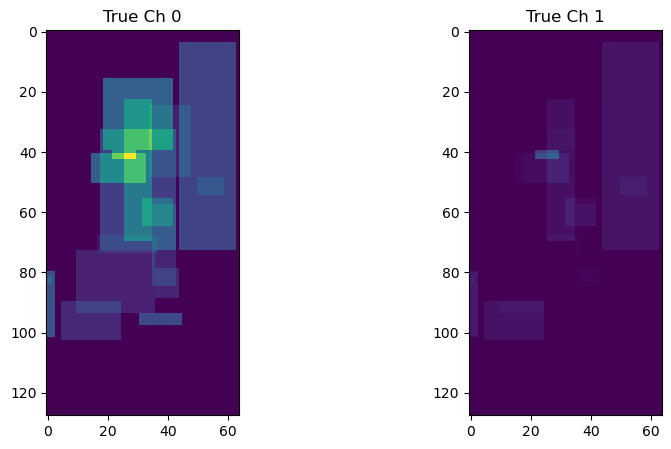

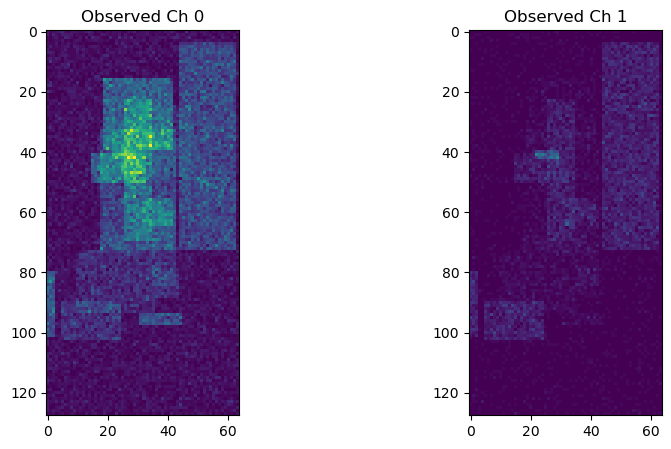

In [24]:
fig,ax = plt.subplots(1,len(alpha_arr_lst),figsize=(10,5))
for ch_idx, alpha_arr in enumerate(alpha_arr_lst):
    im = ax[ch_idx].imshow(alpha_arr)
    ax[ch_idx].set_title(f"True Ch {ch_idx}")
    if ch_idx == 0:
        clim = im.get_clim()
    else:
        im.set_clim(clim)

fig,ax = plt.subplots(1,len(alpha_arr_lst),figsize=(10,5))
for ch_idx, y_arr in enumerate(y_obs_fit_lst):
    im = ax[ch_idx].imshow(y_arr)
    ax[ch_idx].set_title(f"Observed Ch {ch_idx}")
    if ch_idx == 0:
        clim = im.get_clim()
    else:
        im.set_clim(clim)

### Setup Spiral with two variables (single regularizer instance)

In [28]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'

In [29]:
def parallel_pois_fwd_model(**x):
    """
    forward model for parallel polarization channel
    
    expects x['beta'] - backscatter
            x['d'] - depolarization
    returns 
            fwd_mod['y_mean_est']
    """
    fwd_mod = {
        'y_mean_est':torch.exp(x['beta'])*(1-x['d']*0.5)
    }
    return fwd_mod

def perp_pois_fwd_model(**x):
    """
    forward model for perpendicular polarization channel
    
    expects x['beta'] - backscatter
            x['d'] - depolarization
    returns 
            fwd_mod['y_mean_est']
    """
    fwd_mod = {
        'y_mean_est':0.5*torch.exp(x['beta'])*x['d']
    }
    return fwd_mod

In [30]:
fwd_model_lst = [
    parallel_pois_fwd_model,
    perp_pois_fwd_model,
]

y_fit_dct_lst = []
y_val_dct_lst = []

for idx, y_fit in enumerate(y_obs_fit_lst):
    y_fit_dct_lst.append({'counts':y_fit})
    y_val_dct_lst.append({'counts':y_obs_val_lst[idx]})



In [27]:
# importlib.reload(spiral)

In [28]:
# create spiral optimization object
spiral_opt = spiral.multiSpiral_autograd(device,dtype)
spiral_opt.set_fista_version(fista_ver_str)
spiral_opt.set_fwd_model_lst(fwd_model_lst)
spiral_opt.set_y_fit_lst(y_fit_dct_lst)
spiral_opt.set_y_val_lst(y_val_dct_lst)
spiral_opt.set_noise_model(['poisson','poisson'])

In [29]:
# check for alignment between observations and the noise model inputs
pass_test_bool, out_text, = spiral_opt.check_noise_model_inputs()
print(f"check passed: {pass_test_bool}")
print(out_text)

check passed: True
fit data is does not have a dictionary entry for optional input channel_mask in channel 0
validation data is does not have a dictionary entry for optional input channel_mask in channel 0
fit data is does not have a dictionary entry for optional input channel_weight in channel 0
validation data is does not have a dictionary entry for optional input channel_weight in channel 0
fit data is does not have a dictionary entry for optional input channel_mask in channel 1
validation data is does not have a dictionary entry for optional input channel_mask in channel 1
fit data is does not have a dictionary entry for optional input channel_weight in channel 1
validation data is does not have a dictionary entry for optional input channel_weight in channel 1



In [30]:
sparsa_subprob_config_dct = {
    'beta':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    'd':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    }
    }

In [31]:
# set the initial conditions
x0 = {
    'beta':np.zeros(y_obs_fit_lst[0].shape)+np.log(10),
    'd':np.zeros(y_obs_fit_lst[0].shape)+0.1,
}

In [32]:
spiral_opt.set_estimate_lst(['beta','d'])

# this is where the subproblems for each variable get created, so there needs to be an entry for each
spiral_opt.add_sparsa_config(sparsa_subprob_config_dct)
spiral_opt.set_initial_conditions(x0)
spiral_opt.set_tv_penalties({'beta':1e0,'d':1e1})  # this must happen after the subproblem is defined
spiral_opt.verbose = False

In [33]:
spiral_opt.solve()

'Exceeded maximum of 100 iterations'

In [34]:
x_sol = spiral_opt.get_x()
vld_loss = spiral_opt.valid_loss()  # this is used for TV regularization optimization

In [35]:
print(f"Validation Loss: {vld_loss}")

Validation Loss: -89389.0867589829


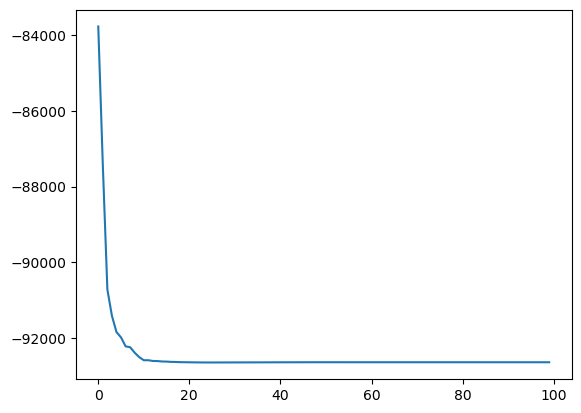

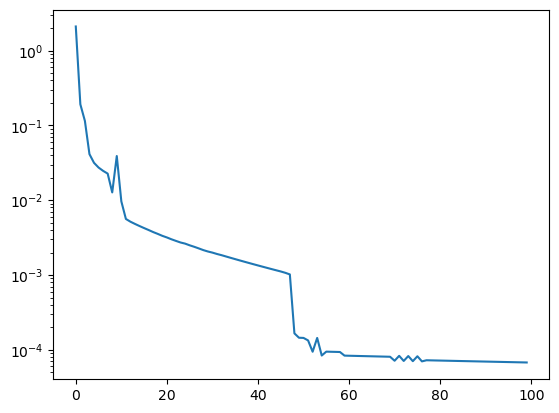

In [36]:
plt.figure()
plt.plot(spiral_opt.loss_lst)

plt.figure()
plt.plot(spiral_opt.step_size_lst)
plt.yscale('log')

In [37]:
import copy
x_act_test = copy.deepcopy(x_act)
x_act_test['beta'] = x_act_test['beta']

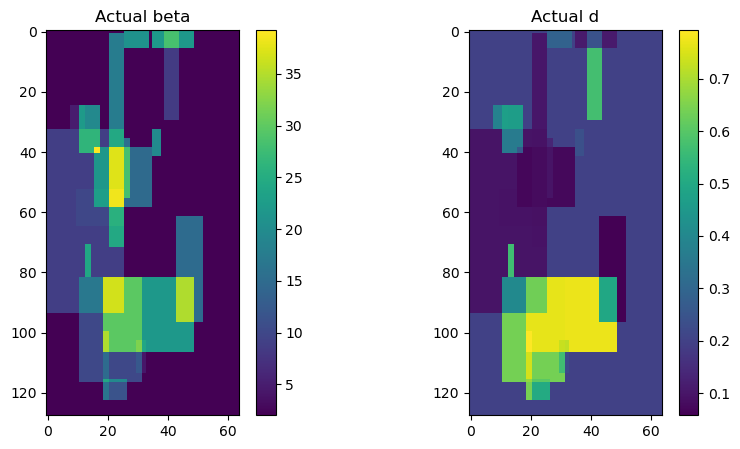

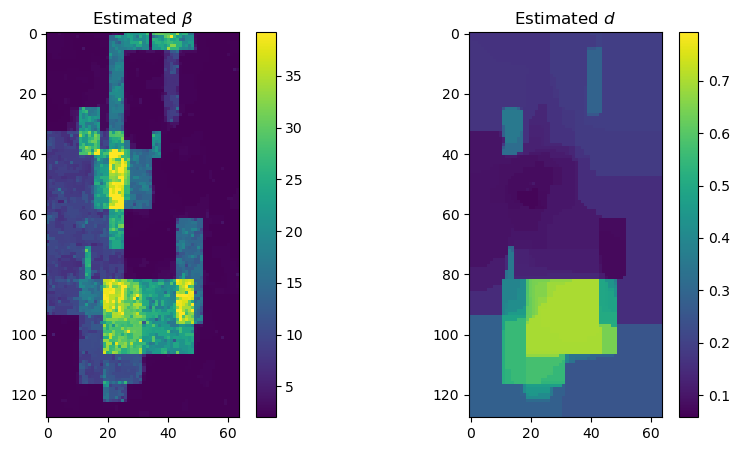

In [38]:
plt_x_dct = {
    'beta':{'function':np.exp,'label':r'$\beta$'},
    'd':{'label':r'$d$'}
}
clim_dct = {}

fig,ax = plt.subplots(1,len(x_act.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_act_test):
    im = ax[var_idx].imshow(x_act_test[var])
    ax[var_idx].set_title(f"Actual {var}")
    clim_dct[var] = im.get_clim()
    plt.colorbar(im,ax=ax[var_idx])
    

fig,ax = plt.subplots(1,len(x_sol.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_sol):
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    im = ax[var_idx].imshow(plot_arr)
    ax[var_idx].set_title(f"Estimated "+plt_x_dct[var]['label'])
    im.set_clim(clim_dct[var])
    plt.colorbar(im,ax=ax[var_idx])
    # if ch_idx == 0:
    #     clim = im.get_clim()
    # else:
    #     im.set_clim(clim)

plot forward model comparison

In [39]:
fwd_model_dct_lst = []
for idx, model in enumerate(spiral_opt.fwd_model_lst):
    y_est = model(**spiral_opt.x)
    fwd_dct = {}
    for var in y_est:
        fwd_dct[var] = y_est[var].detach().cpu()
    fwd_model_dct_lst.append(fwd_dct)

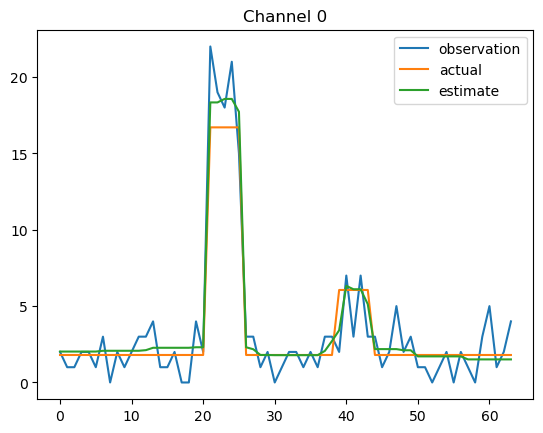

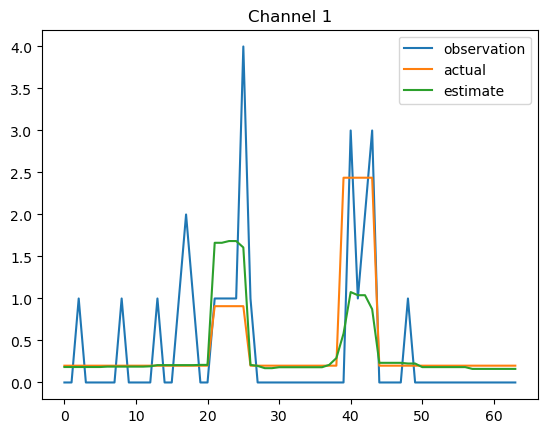

In [40]:
obs_var = 'counts'
fwd_mod_var = 'y_mean_est'
time_idx = 20

for idx, fwd_mod in enumerate(fwd_model_dct_lst):
    plt.figure()
    plt.plot(y_fit_dct_lst[idx][obs_var][time_idx,:],label='observation')
    plt.plot(alpha_arr_lst[idx][time_idx,:],label='actual')
    plt.plot(fwd_mod[fwd_mod_var][time_idx,:],label='estimate')
    plt.legend()
    plt.title(f"Channel {idx}")

### Full regularizer optimization
Using the samme forward model and observations from the previous single regularizer instance, we now expand the processing to optimize the total variation regularization.  In this case we employ a simple grid search to locate the best regularizer solution.

In [35]:
tv_reg_dct = {
    'd':np.logspace(0.8,1.5,5),
    'beta':np.logspace(0,0.7,5),
}

In [36]:
# create regularizer grid
tv_lst = []
for var in tv_reg_dct:
    tv_lst.append(tv_reg_dct[var])

tv_mesh_tup = np.meshgrid(*tv_lst)

grid_count = tv_mesh_tup[0].size

In [37]:
# create spiral optimization object
spiral_opt = spiral.multiSpiral_autograd(device,dtype)
spiral_opt.set_fista_version(fista_ver_str)
spiral_opt.set_fwd_model_lst(fwd_model_lst)
spiral_opt.set_y_fit_lst(y_fit_dct_lst)
spiral_opt.set_y_val_lst(y_val_dct_lst)
spiral_opt.set_noise_model(['poisson','poisson'])

In [38]:
# check for alignment between observations and the noise model inputs
pass_test_bool, out_text, = spiral_opt.check_noise_model_inputs()
print(f"check passed: {pass_test_bool}")
print(out_text)

check passed: True
fit data is does not have a dictionary entry for optional input channel_mask in channel 0
validation data is does not have a dictionary entry for optional input channel_mask in channel 0
fit data is does not have a dictionary entry for optional input channel_weight in channel 0
validation data is does not have a dictionary entry for optional input channel_weight in channel 0
fit data is does not have a dictionary entry for optional input channel_mask in channel 1
validation data is does not have a dictionary entry for optional input channel_mask in channel 1
fit data is does not have a dictionary entry for optional input channel_weight in channel 1
validation data is does not have a dictionary entry for optional input channel_weight in channel 1



In [39]:
sparsa_subprob_config_dct = {
    'beta':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    'd':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    }
    }

In [40]:
# set the initial conditions
x0 = {
    'beta':np.zeros(y_obs_fit_lst[0].shape)+np.log(10),
    'd':np.zeros(y_obs_fit_lst[0].shape)+0.1,
}

In [41]:
spiral_opt.set_estimate_lst(['beta','d'])

# this is where the subproblems for each variable get created, so there needs to be an entry for each
spiral_opt.add_sparsa_config(sparsa_subprob_config_dct)
spiral_opt.set_initial_conditions(x0)
# spiral_opt.set_tv_penalties({'beta':1e0,'d':1e1})  # this must happen after the subproblem is defined
spiral_opt.verbose = False

In [ ]:
x_sol_lst = []
vld_loss_lst = []
opt_time_lst = []
for idx in range(grid_count):
    tv_dct = {}
    for var_idx, var in enumerate(tv_reg_dct):
        tv_dct[var] = tv_mesh_tup[var_idx].flatten()[idx]
        print(var+f": {tv_mesh_tup[var_idx].flatten()[idx]}")
    spiral_opt.set_tv_penalties(tv_dct)  # this must happen after the subproblem is defined
    
    # reinitialize
    # spiral_opt.set_alpha(1.0)
    spiral_opt.set_initial_conditions(x0)
    
    # optimize
    spiral_opt.solve()

    # store result
    x_sol = spiral_opt.get_x()
    x_sol_lst.append(x_sol)
    vld_loss = spiral_opt.valid_loss()  # this is used for TV regularization optimization
    vld_loss_lst.append(vld_loss)
    opt_time_lst.append(spiral_opt.stop_time - spiral_opt.start_time)
    print(f"validation loss: {vld_loss}")
    print(f"optimization time: {opt_time_lst[-1]} seconds")
    print()

d: 6.3095734448019325
beta: 1.0
validation loss: -65313.655712011954
optimization time: 125.00451040267944 seconds

d: 9.440608762859235
beta: 1.0
validation loss: -65234.1879209236
optimization time: 107.00536251068115 seconds

d: 14.12537544622754
beta: 1.0
validation loss: -65064.26932790337
optimization time: 117.1972484588623 seconds

d: 21.134890398366466
beta: 1.0
validation loss: -64859.58462504891
optimization time: 104.01744675636292 seconds

d: 31.622776601683796
beta: 1.0
validation loss: -64563.68686150958
optimization time: 96.65610694885254 seconds

d: 6.3095734448019325
beta: 1.4962356560944334
validation loss: -65503.42008481422
optimization time: 121.64281392097473 seconds

d: 9.440608762859235
beta: 1.4962356560944334
validation loss: -65423.952293726805
optimization time: 100.35734367370605 seconds

d: 14.12537544622754
beta: 1.4962356560944334
validation loss: -65254.033700706575
optimization time: 108.66506576538086 seconds

d: 21.134890398366466
beta: 1.496235656

In [ ]:
sol_idx = np.argmin(vld_loss_lst)
x_sol = x_sol_lst[sol_idx]

In [ ]:
var_idx_x = 0
var_idx_y = 1

fig,ax = plt.subplots(1,1,figsize=(5,5))
tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
tv_var_y = list(tv_reg_dct.keys())[var_idx_y]

im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),tv_mesh_tup[var_idx_y].flatten(),c=vld_loss_lst)
ax.plot(tv_mesh_tup[var_idx_x].flatten()[sol_idx],tv_mesh_tup[var_idx_y].flatten()[sol_idx],'wx')
ax.set_xlabel(tv_var_x + " Regularizer")
ax.set_ylabel(tv_var_y + " Regularizer")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(visible=True)
plt.colorbar(im,ax=ax,label="validation NLL")


In [ ]:
plt_x_dct = {
    'beta':{'function':np.exp,'label':r'$\beta$'},
    'd':{'label':r'$d$'}
}
clim_dct = {}

fig,ax = plt.subplots(1,len(x_act.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_act_test):
    im = ax[var_idx].imshow(x_act_test[var])
    ax[var_idx].set_title(f"Actual "+plt_x_dct[var]['label'])
    clim_dct[var] = im.get_clim()
    plt.colorbar(im,ax=ax[var_idx])
    

fig,ax = plt.subplots(1,len(x_sol.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_sol):
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    im = ax[var_idx].imshow(plot_arr)
    ax[var_idx].set_title(f"Estimated "+plt_x_dct[var]['label'])
    im.set_clim(clim_dct[var])
    plt.colorbar(im,ax=ax[var_idx])

In [ ]:
fwd_model_dct_lst = []

x_sol_tnsr = {}

for var in x_sol:
    x_sol_tnsr[var] = spiral_opt.to_tensor(x_sol[var])

for idx, model in enumerate(spiral_opt.fwd_model_lst):
    y_est = model(**x_sol_tnsr)
    fwd_dct = {}
    for var in y_est:
        fwd_dct[var] = y_est[var].detach().cpu()
    fwd_model_dct_lst.append(fwd_dct)

In [ ]:
obs_var = 'counts'
fwd_mod_var = 'y_mean_est'
time_idx = 20

for idx, fwd_mod in enumerate(fwd_model_dct_lst):
    plt.figure()
    plt.plot(y_fit_dct_lst[idx][obs_var][time_idx,:],label='observation')
    plt.plot(alpha_arr_lst[idx][time_idx,:],label='actual')
    plt.plot(fwd_mod[fwd_mod_var][time_idx,:],label='estimate')
    plt.legend()
    plt.title(f"Channel {idx}")

# Gaussian Noise

### Generate some data to denoise

In [410]:
x_axis = np.linspace(-10,10,64)
y_axis = np.linspace(-10,10,128)
x_ax_mesh,y_ax_mesh = np.meshgrid(x_axis,y_axis)

rec_count = 80

# uniform distribution
# rec_x_position_arr = 20*(np.random.rand(rec_count)-0.5)
# rec_y_position_arr = 20*(np.random.rand(rec_count)-0.5)
# normal distribution
rec_x_position_arr = 5*(np.random.randn(rec_count))
rec_y_position_arr = 5*(np.random.randn(rec_count))
rec_x_arr = np.random.randn(rec_count)*5
rec_y_arr = np.random.randn(rec_count)*5
mu_rec_arr = 20*np.random.rand(rec_count)
sig_rec_arr = 10*np.random.rand(rec_count)

mu_arr = np.zeros((y_axis.size,x_axis.size))
sig_arr = np.zeros((y_axis.size,x_axis.size))

for idx in range(rec_count):
    rec_idx = np.where((y_ax_mesh >= rec_y_position_arr[idx]-rec_y_arr[idx]/2) & (y_ax_mesh <= rec_y_position_arr[idx]+rec_y_arr[idx]/2) & \
             (x_ax_mesh >= rec_x_position_arr[idx]-rec_x_arr[idx]/2) & (x_ax_mesh <= rec_x_position_arr[idx]+rec_x_arr[idx]/2))
    mu_arr[rec_idx]+=mu_rec_arr[idx]
    sig_arr[rec_idx]+=sig_rec_arr[idx]

mu_arr+= 4
sig_arr+=2

In [412]:
# create fit and validation data for the scene
y_obs_fit = np.random.randn(*mu_arr.shape)*sig_arr + mu_arr
y_obs_val = np.random.randn(*mu_arr.shape)*sig_arr + mu_arr

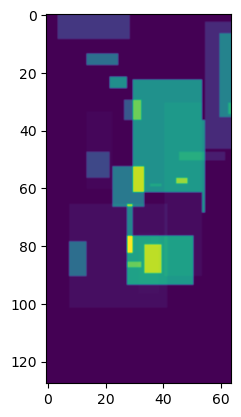

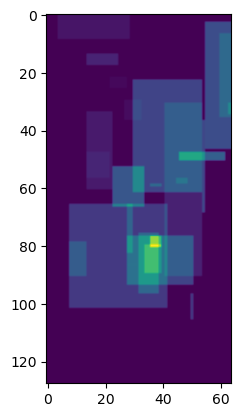

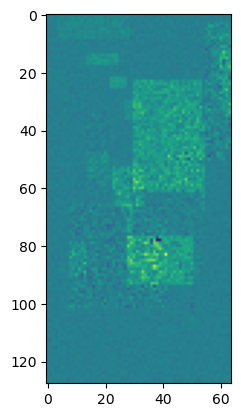

In [415]:
plt.figure()
plt.imshow(mu_arr)

plt.figure()
plt.imshow(sig_arr)

plt.figure()
plt.imshow(y_obs_fit)

### Example of single Sparsa subproblem
Basic one-off setup for single sparse instance

In [416]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'
max_iter = 2000
loss_fnc = loss.gaus_fn

In [417]:
def fwd_model_photons(**x):
    # really simple direct forward model
    return {'y_mean_est': x['backscatter_mean'], 'y_var_est': torch.exp(x['backscatter_var'])+1e-20}

In [420]:
x0 = {'backscatter_mean':torch.zeros(y_obs_fit.shape,dtype=dtype,device=device),
     'backscatter_var':torch.zeros(y_obs_fit.shape,dtype=dtype,device=device)}

In [421]:
y_obs_dct_lst = [
    {'counts':torch.tensor(y_obs_fit,dtype=dtype,device=device),
    'shot_count':torch.ones((y_obs_fit.shape[0],1),dtype=dtype,device=device)},
]
fwd_model_lst = [fwd_model_photons]

In [ ]:
subprob = sparsa.sparsa_torch_autograd(device,dtype)
subprob.load_fit_parameters(x0,
                            y_obs_dct_lst,
                            fwd_model_lst,
                            'backscatter')
subprob.set_loss_fn(loss_fnc)
subprob.set_fista(fista_ver_str) # use jit-fista
subprob.set_penalty_weight(1.0e0)
subprob.set_max_iter(max_iter)
subprob.set_alpha_min(1e3)  # this is pretty key to establishing stability in the processing.  1 is too small.
subprob.alpha
# subprob.set_alpha(1e8)